In [0]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator
plt.style.use('seaborn')
%matplotlib inline

In [0]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/RenzoGuzman/Files-COVID-19-Peru/master/time_series_covid19_confirmed_peru_vf.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/RenzoGuzman/Files-COVID-19-Peru/master/time_series_covid19_deaths_peru_vf.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/RenzoGuzman/Files-COVID-19-Peru/master/time_series_covid19_recovered_peru_vf.csv')

In [0]:
confirmed_df.head()

,Province/State,Country/Region,Lat,Long,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20
0,NaN,Peru,-9.19,-75.0152,1,1,6,7,11,11,15,28,38,43,86,117,145,234,234,318,363,395,416,480,580,635,671,852,950,1065,1323,1414,1595,1746,2281,2561,2954,4342,5256,5897,6848,7519,9784,10303,11475,12491,13489,14420


In [0]:
deaths_df.head()

,Province/State,Country/Region,Lat,Long,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20
0,NaN,Peru,-9.19,-75.0152,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,5,5,5,7,9,9,11,16,18,24,30,38,55,61,73,83,92,107,121,138,169,181,193,216,230,254,274,300,348


In [0]:
recoveries_df.head()

,Province/State,Country/Region,Lat,Long,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20
0,NaN,Peru,-9.19,-75.0152,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,14,16,16,16,53,394,394,537,537,914,989,997,1301,1333,1438,1569,1739,1798,2642,2869,3108,6120,6541,6648


In [0]:
cols = confirmed_df.keys()

In [0]:
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]

In [0]:
dates = confirmed.keys()
world_cases = []
total_deaths = [] 
mortality_rate = []
total_recovered = [] 

for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    mortality_rate.append(death_sum/confirmed_sum)
    total_recovered.append(recovered_sum)

In [0]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)
total_recovered = np.array(total_recovered).reshape(-1, 1)

In [0]:
days_in_future = 5
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-5]

In [0]:
start = '3/06/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [0]:
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22, world_cases, test_size=0.15, shuffle=False)


In [0]:
kernel = ['poly', 'sigmoid', 'rbf']
c = [0.01, 0.1, 1, 10]
gamma = [0.01, 0.1, 1]
epsilon = [0.01, 0.1, 1]
shrinking = [True, False]
svm_grid = {'kernel': kernel, 'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking}

svm = SVR()
svm_search = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=5, return_train_score=True, n_jobs=-1, n_iter=100, verbose=1)
svm_search.fit(X_train_confirmed, y_train_confirmed)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 497 out of 500 | elapsed: 17.9min remaining:    6.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 18.2min finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=100, n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 1, 10],
                                        'epsilon': [0.01, 0.1, 1],
                                        'gamma': [0.01, 0.1, 1],
                                        'kernel': ['poly', 'sigmoid', 'rbf'],
                                        'shrinking': [True, False]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [0]:
svm_search.best_params_


{'C': 10, 'epsilon': 1, 'gamma': 1, 'kernel': 'poly', 'shrinking': True}

In [0]:
svm_confirmed = svm_search.best_estimator_
svm_pred = svm_confirmed.predict(future_forcast)

MAE: 5534.342573117683
MSE: 32430781.05488227


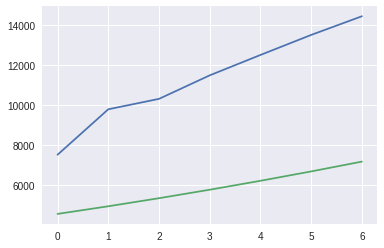

In [0]:
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(y_test_confirmed)
plt.plot(svm_test_pred)
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))

In [0]:
linear_model = LinearRegression(normalize=True, fit_intercept=True)
linear_model.fit(X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(X_test_confirmed)
linear_pred = linear_model.predict(future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

MAE: 7306.468874889928
MSE: 57118105.95186292


In [0]:
print(linear_model.coef_[0][0])
print(linear_model.intercept_[0])

130.04362256993835
-1153.7852062588904


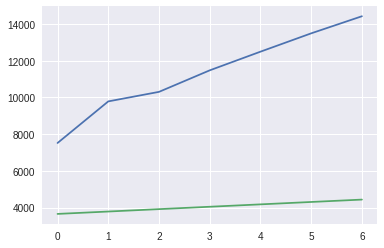

In [0]:
plt.plot(y_test_confirmed)
plt.plot(test_linear_pred)

In [0]:
tol = [1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2}

bayesian = BayesianRidge()
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(X_train_confirmed, y_train_confirmed)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                                           alpha_init=None, compute_score=False,
                                           copy_X=True, fit_intercept=True,
                                           lambda_1=1e-06, lambda_2=1e-06,
                                           lambda_init=None, n_iter=300,
                                           normalize=False, tol=0.001,
                                           verbose=False),
                   iid='deprecated', n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                                 

In [0]:
bayesian_search.best_params_


{'alpha_1': 1e-06,
 'alpha_2': 0.0001,
 'lambda_1': 0.0001,
 'lambda_2': 0.0001,
 'tol': 0.01}

In [0]:
bayesian_confirmed = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_confirmed.predict(X_test_confirmed)
bayesian_pred = bayesian_confirmed.predict(future_forcast)
print('MAE:', mean_absolute_error(test_bayesian_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_bayesian_pred, y_test_confirmed))

MAE: 7350.390647111986
MSE: 57777084.21474517


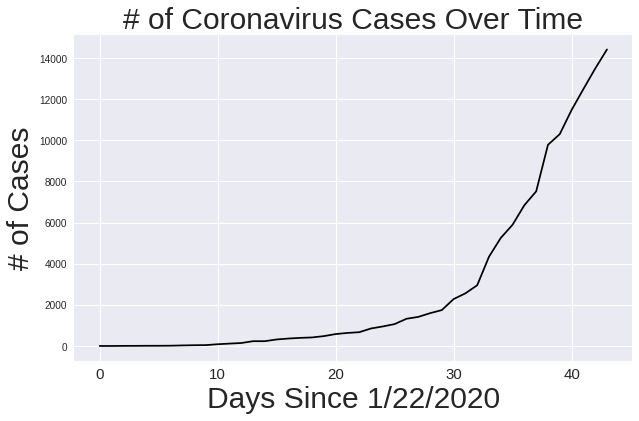

In [0]:
plt.figure(figsize=(10, 6))
plt.plot(adjusted_dates, world_cases, color='black')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=15)
plt.show()

# SVM Model

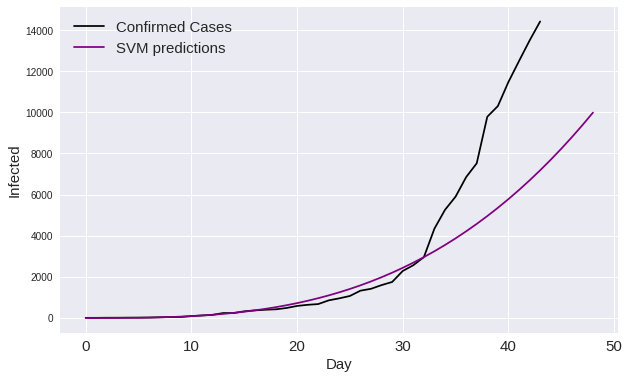

In [0]:
plt.figure(figsize=(10, 6))
plt.plot(adjusted_dates, world_cases, color='black')
plt.plot(future_forcast, svm_pred, color='purple')
plt.xlabel('Day', size=15)
plt.ylabel('Infected', size=15)
plt.legend(['Confirmed Cases', 'SVM predictions'], loc='best', fontsize=15)
plt.xticks(size=15)
plt.show()

# Linear Regression Model

In [0]:
svm_pred

array([-5.49249290e+00, -5.40214584e+00, -4.76971641e+00, -3.05312225e+00,
        2.89719000e-01,  5.80088971e+00,  1.40224723e+01,  2.54965490e+01,
        4.07652023e+01,  6.03705144e+01,  8.48545680e+01,  1.14759445e+02,
        1.50627229e+02,  1.93000000e+02,  2.42419842e+02,  2.99428838e+02,
        3.64569069e+02,  4.38382618e+02,  5.21411566e+02,  6.14197998e+02,
        7.17283994e+02,  8.31211639e+02,  9.56523014e+02,  1.09376020e+03,
        1.24346528e+03,  1.40618034e+03,  1.58244745e+03,  1.77280871e+03,
        1.97780619e+03,  2.19798198e+03,  2.43387815e+03,  2.68603680e+03,
        2.95500000e+03,  3.24130984e+03,  3.54550839e+03,  3.86813776e+03,
        4.20973997e+03,  4.57085719e+03,  4.95203143e+03,  5.35380481e+03,
        5.77671941e+03,  6.22131729e+03,  6.68814056e+03,  7.17773129e+03,
        7.69063156e+03,  8.22738345e+03,  8.78852902e+03,  9.37461044e+03,
        9.98616968e+03])

# Bayesian Ridge Regression Predictions

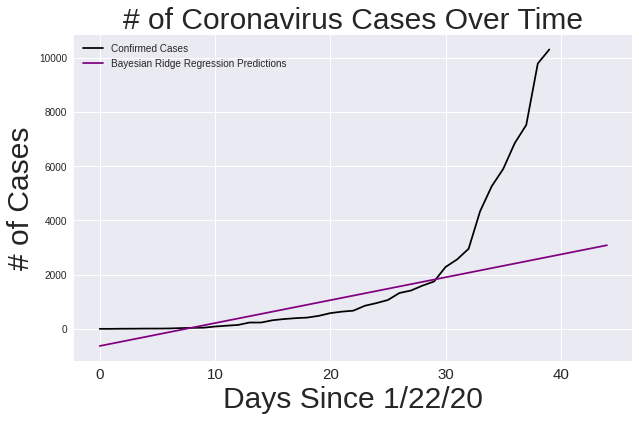

In [0]:
plt.figure(figsize=(10, 6))
plt.plot(adjusted_dates, world_cases, color='black')
plt.plot(future_forcast, bayesian_pred, color='purple')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/20', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Confirmed Cases', 'Bayesian Ridge Regression Predictions'])
plt.xticks(size=15)
plt.show()

# All Predictions

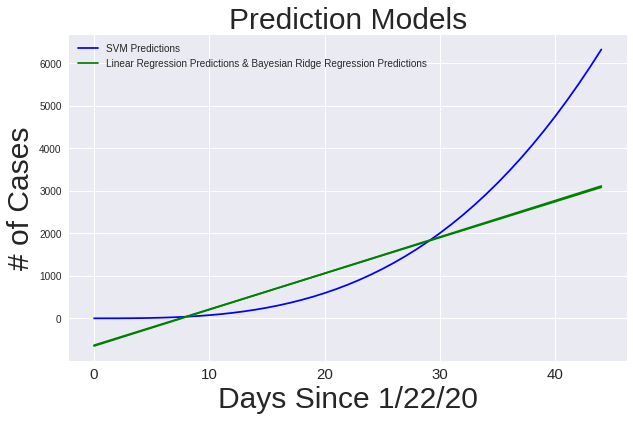

In [0]:
plt.figure(figsize=(10, 6))
plt.plot(future_forcast, svm_pred, color='blue')
plt.plot(future_forcast, linear_pred, color='green')
plt.plot(future_forcast, bayesian_pred, color='green')
plt.title('Prediction Models', size=30)
plt.xlabel('Days Since 1/22/20', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['SVM Predictions', 'Linear Regression Predictions & Bayesian Ridge Regression Predictions'])
plt.xticks(size=15)
plt.show()

In [0]:
from datetime import date
today = date.today()
print(today)

2020-04-15


In [0]:
data_start_date = datetime.date(2020, 3, 6)
delta = today - data_start_date
days_diff = delta.days
print(days_diff)

40


# All Predictions with "Today" Indicator

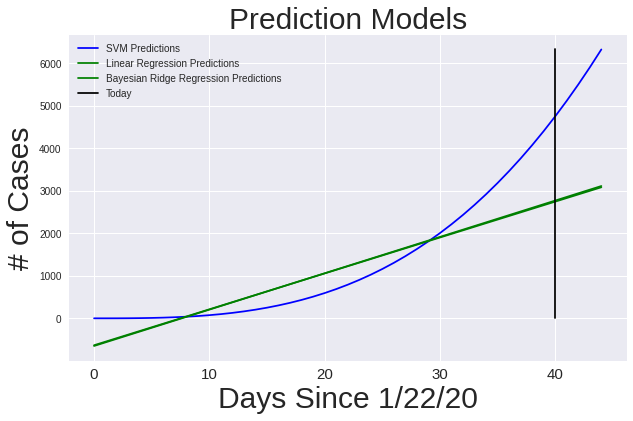

In [0]:
plt.figure(figsize=(10, 6))
plt.plot(future_forcast, svm_pred, color='blue')
plt.plot(future_forcast, linear_pred, color='green')
plt.plot(future_forcast, bayesian_pred, color='green')
plt.plot([days_diff, days_diff], [0, max(svm_pred)], color ='black')
plt.title('Prediction Models', size=30)
plt.xlabel('Days Since 1/22/20', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['SVM Predictions', 'Linear Regression Predictions', 'Bayesian Ridge Regression Predictions', 'Today'])
plt.xticks(size=15)
plt.show()

# Calculus Application in Refining COVID-19 Model

While the linear regression model may not be the best future indicator for coronavirus cases, tracking the linear regression slope each and every single day can still offer invaluable insight as to whether or not the spread of coronavirus is slowing down.

We can use calculus to achieve this.
Refer to First and Second Derivative Test.

In [0]:
import sympy as sym
x = sym.Symbol('x')
sym.diff(x**5)

5*x**4

In [0]:
intercept = linear_model.intercept_[0]
coefficient = linear_model.coef_[0][0]
x = sym.Symbol('x')
slope = sym.diff(coefficient*x + intercept)

print("As of today: Linear equation C(x) = " + str(coefficient) + "x + " + str(intercept))
print("Derivative C'(x) = " + str(slope) + "x")

As of today: Linear equation C(x) = 85.49793735676086x + -648.4218487394953
Derivative C'(x) = 85.4979373567609x


In [0]:
from csv import writer

with open("COVID-19-First-Derivative.csv", 'a+', newline='') as write_obj:
    csv_writer = writer(write_obj)
    csv_writer.writerow([today, sym.diff(coefficient*x + intercept)])

fd = pd.read_csv("COVID-19-First-Derivative.csv")
fd = fd.drop_duplicates(subset='Date')
fd.head()

,2020-04-15,85.4979373567609


They key is to collect the rate of change (cases/day) each and every single day and run linear regression on the last couple of rates to determine whether or not the rate of change (cases/day) is slowing down or not. Hopefully, it's slowing down.